# Classification - Is the flight delayed or not ?

This notebook will focus on classification of flights based on flights information, before going through regression analysis.

Through this notebook we are going to try different techniques to build and improve our model's performance:
 - Use cross-validation techniques
 - Feature engineering
 - Handle the class imbalance of the target variable
 - Try different modelling techniques - Stacking classifier, Voting classifiers, ensembling...
 - Data transformations
 - Feature Selection techniques such as RFE, Tree-based feature importance...

Table of contents:

1. [Import relevant libraries](#Libraries)
2. [Load files](#Load)
3. [Preview files](#Preview)
5. [Data exploration and transformation](#Exploration)
6. [Target distribution](#Target)
7. [Outliers](#Outliers)
8. [Correlations](#Correlations)
9. [Model training](#Model)
10. [Test set predictions](#Predictions)
11. [Creating a submission file](#Submission)
12. [Tips to improve model performance](#Tips)

<a name = "Libraries"></a>
## 1. Import relevant libraries

In [365]:
# Pre-requisites
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import s3fs
import config

# Store the classifier models to save time
import joblib

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Classifiers from scikit-learn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Performance metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Imbalanced dataset helpers
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

import pickle
import dill

pd.set_option('display.max_columns', None)

<a name = "Load"></a>
## 2. Load files

In [366]:
# Create an S3 file system object
s3 = s3fs.S3FileSystem(anon=False, key=config.ACCESS_KEY_ID, secret=config.SECRET_ACCESS_KEY)

# Specify the S3 path to Parquet file
s3_path = 's3://flights-delay-prediction-jihed-output/processed/eventdate=20240507/output.parquet'

# Use pandas to read the Parquet file directly from S3
df = pd.read_parquet(s3_path, filesystem=s3)

<a name = "Preview"></a>
## 3. Preview files

In [367]:
df.head()

,aircraft,airport,rounded_hour,date,from,to,flight,flight_time,scheduled_time_departure,actual_time_departure,scheduled_time_arrival,status,actual_time_arrival,from_city,to_city,delay_time,temperature,dew_point,humidity,wind_speed,wind_gust,pressure,precip,my_flightradar24_rating,arrival_delay_index,departure_delay_index,msn,type,airline,age
0,ei-dwe,crl,2023-08-18 22:00:00,2023-08-18,man,crl,FR3238,1.016667,2023-08-18 19:30:00,2023-08-18 19:59:00,2023-08-18 21:50:00,On Time,2023-08-18 22:00:00,manchester,brussels,10.0,73,68,83,6,0,29.260000,0.0,63,0.4,1.2,36074,B738,Ryanair,16.0
1,a9c-dhab,bah,2023-08-21 22:00:00,2023-08-21,dxb,bah,ES262,0.900000,2023-08-20 23:04:00,2023-08-21 22:10:00,2023-08-21 22:04:00,On Time,2023-08-21 22:04:00,dubai,bahrain,0.0,95,84,71,9,0,29.580000,0.0,78,0.4,0.8,29606,B763,DHL (No. 1 Best Workplace Stickers),24.0
2,hb-jba,vie,2023-10-08 21:00:00,2023-10-08,gva,vie,LX1598,1.316667,2023-10-08 19:00:00,2023-10-08 19:07:00,2023-10-08 20:35:00,On Time,2023-10-08 20:26:00,geneva,vienna,-9.0,54,45,72,7,0,29.700001,0.0,85,0.4,0.7,50010,BCS1,Swiss,7.0
3,9v-sfi,bru,2024-01-25 12:00:00,2024-01-25,dfw,bru,SQ7951,8.233333,2024-01-25 19:50:00,2024-01-25 20:28:00,2024-01-25 11:55:00,On Time,2024-01-25 11:42:00,dallas,brussels,-13.0,45,45,100,7,0,30.280001,0.0,81,0.4,0.8,28027,B744,Singapore Airlines,23.0
4,ra-73249,msq,2024-03-28 19:00:00,2024-03-28,led,msq,DP893,1.066667,2024-03-28 17:10:00,2024-03-28 17:22:00,2024-03-28 18:45:00,On Time,2024-03-28 18:25:00,st. petersburg,minsk,-20.0,50,37,62,13,20,28.820000,0.0,71,2.5,2.5,41241,B738,Pobeda,5.0


<a name = "Exploration"></a>
## 5. Data exploration and transformation

In [368]:
df.dtypes

aircraft                            object
airport                             object
rounded_hour                datetime64[ns]
date                                object
from                                object
to                                  object
flight                              object
flight_time                        float64
scheduled_time_departure    datetime64[ns]
actual_time_departure       datetime64[ns]
scheduled_time_arrival      datetime64[ns]
status                              object
actual_time_arrival         datetime64[ns]
from_city                           object
to_city                             object
delay_time                         float64
temperature                          int32
dew_point                            int32
humidity                             int32
wind_speed                           int32
wind_gust                            int32
pressure                           float32
precip                             float32
my_flightra

Axes(0.125,0.125;0.698618x0.755)


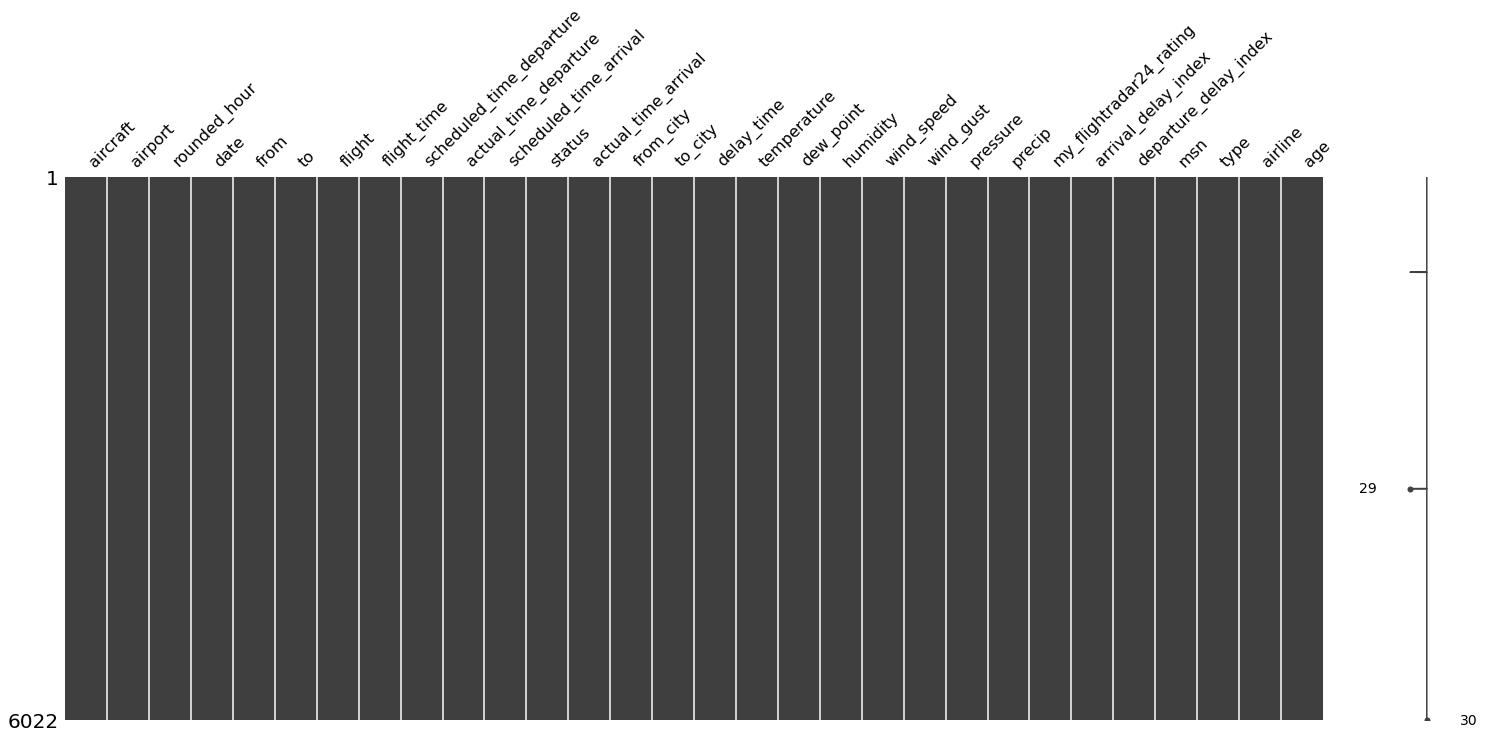

In [369]:
print(msno.matrix(df))

In [370]:
df.dropna(inplace=True)

In [371]:
# Check for any missing values
df.isnull().sum().any()

False

In [372]:
# Check for duplicates
df.duplicated().sum()

0

In [373]:
df['status'] = df['status'].map({"On Time": 0, "Delayed": 1}).astype('int')

df["departure_delay"] = df["actual_time_departure"] - df["scheduled_time_departure"]

# Convert the departure delay to minutes
df['departure_delay'] = df['departure_delay'].dt.total_seconds() / 60

df["departure_delay_15"] = (df["departure_delay"] > 15).astype('int')

df['year'] = df['scheduled_time_arrival'].dt.year
df['month'] = df['scheduled_time_arrival'].dt.month
df['day'] = df['scheduled_time_arrival'].dt.day
df['hour'] = df['scheduled_time_arrival'].dt.hour
df['dayofweek'] = df['scheduled_time_arrival'].dt.dayofweek
df['quarter'] = df['scheduled_time_arrival'].dt.quarter
df['is_year_start'] = df['scheduled_time_arrival'].dt.is_year_start.astype('int')
df['is_year_end'] = df['scheduled_time_arrival'].dt.is_year_end.astype('int')

In [374]:
print(list(df.columns))

['aircraft', 'airport', 'rounded_hour', 'date', 'from', 'to', 'flight', 'flight_time', 'scheduled_time_departure', 'actual_time_departure', 'scheduled_time_arrival', 'status', 'actual_time_arrival', 'from_city', 'to_city', 'delay_time', 'temperature', 'dew_point', 'humidity', 'wind_speed', 'wind_gust', 'pressure', 'precip', 'my_flightradar24_rating', 'arrival_delay_index', 'departure_delay_index', 'msn', 'type', 'airline', 'age', 'departure_delay', 'departure_delay_15', 'year', 'month', 'day', 'hour', 'dayofweek', 'quarter', 'is_year_start', 'is_year_end']


In [375]:
label_encoders = {}
value_mappings = {}

columns_to_encode = ["flight", "from", "to", "from_city", "to_city"]
for column in columns_to_encode:
    le = CustomLabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le
    
    # Create a dictionary mapping actual values to encoded values
    value_mappings[column] = {value: le.transform([value])[0] for value in le.classes_}
    
# Save the LabelEncoders and value mappings to disk using dill
with open('custom_label_encoders.pkl', 'wb') as f:
    dill.dump(label_encoders, f)

with open('value_mappings.pkl', 'wb') as f:
    dill.dump(value_mappings, f)

# Display the value mappings
value_mappings

{'flight': {'(BCS207P)': 0,
  '(BCS232P)': 1,
  '(BCS3KC)': 2,
  '(BCS415P)': 3,
  '(BCS55G)': 4,
  '(BCS8AA)': 5,
  '(BE29Q)': 6,
  '(BEL256L)': 7,
  '(BEL2CK)': 8,
  '(BLX924P)': 9,
  '(CLX1E)': 10,
  '(CLX2DW)': 11,
  '(CLX62RB)': 12,
  '(DHK230P)': 13,
  '(DHK2SD)': 14,
  '(DHK841P)': 15,
  '(DHX268A)': 16,
  '(EZE032P)': 17,
  '(HMR101)': 18,
  '(JAF025F)': 19,
  '(JAF066K)': 20,
  '(JAF081F)': 21,
  '(JAF903P)': 22,
  '(JAF929P)': 23,
  '(JAF942P)': 24,
  '(JAF979F)': 25,
  '(RYR138)': 26,
  '(RYR402)': 27,
  '(RYR502)': 28,
  '(RYR60)': 29,
  '(RYR641)': 30,
  '(RYR66)': 31,
  '(RYR69)': 32,
  '(RYR6DE)': 33,
  '(RYR8487)': 34,
  '(RYR911)': 35,
  '(TOM926P)': 36,
  '(TUI872P)': 37,
  '(TUI939P)': 38,
  '(TVS430P)': 39,
  '(TVS435P)': 40,
  '(TVS438P)': 41,
  '(TVS447P)': 42,
  '(WZZ410)': 43,
  '2S623': 44,
  '2S625': 45,
  '3S520': 46,
  '3S539': 47,
  '3S543': 48,
  '4M853': 49,
  '6E1201': 50,
  '6E1211': 51,
  '6E1803': 52,
  '6H247': 53,
  'AC832': 54,
  'AC834': 55,
  'AC

In [376]:
# Check statistical summaries of the dataset
df.describe()

,from,to,flight,flight_time,status,from_city,to_city,delay_time,temperature,dew_point,humidity,wind_speed,wind_gust,pressure,precip,my_flightradar24_rating,arrival_delay_index,departure_delay_index,age,departure_delay,departure_delay_15,year,month,day,hour,dayofweek,quarter,is_year_start,is_year_end
count,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000,6020.0,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000
mean,128.935714,10.353156,477.875249,2.957027,0.205150,124.153654,9.482060,5.859136,56.877907,46.091030,72.141196,9.523588,1.380565,29.478720,0.0,74.707641,0.939867,1.397060,12.530544,18.085714,0.584884,2023.311794,6.527575,15.652159,12.380233,3.056977,2.502492,0.002159,0.002159
std,76.547388,6.646501,252.597537,2.424575,0.403844,70.562959,5.969561,65.338675,16.268756,13.491785,20.221362,5.629528,6.290909,0.628516,0.0,9.675354,0.884258,0.870452,5.968321,171.189997,0.492783,0.463265,3.654692,8.767792,5.773637,2.002966,1.162275,0.046424,0.046424
min,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,-158.000000,-2.000000,-17.000000,0.000000,0.000000,0.000000,0.000000,0.0,45.000000,0.400000,0.100000,2.000000,-1430.000000,0.000000,2023.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,74.000000,5.000000,277.000000,1.266667,0.000000,72.000000,6.000000,-15.000000,46.000000,39.000000,59.000000,6.000000,0.000000,29.260000,0.0,63.000000,0.400000,0.800000,8.000000,10.000000,0.000000,2023.000000,3.000000,8.000000,8.000000,1.000000,1.000000,0.000000,0.000000
50%,123.000000,7.000000,475.000000,2.066667,0.000000,127.000000,6.000000,-4.000000,55.000000,46.000000,76.000000,9.000000,0.000000,29.510000,0.0,81.000000,0.400000,0.800000,14.000000,19.000000,1.000000,2023.000000,7.000000,15.000000,12.000000,3.000000,3.000000,0.000000,0.000000
75%,184.000000,17.000000,679.000000,3.733333,0.000000,173.000000,15.000000,11.000000,66.000000,54.000000,88.000000,13.000000,0.000000,29.830000,0.0,81.000000,1.400000,2.500000,16.000000,33.000000,1.000000,2024.000000,10.000000,23.000000,17.000000,5.000000,4.000000,0.000000,0.000000
max,277.000000,22.000000,937.000000,23.983333,1.000000,260.000000,21.000000,1429.000000,113.000000,88.000000,100.000000,39.000000,51.000000,30.600000,0.0,85.000000,2.500000,3.500000,40.000000,1428.000000,1.000000,2024.000000,12.000000,31.000000,23.000000,6.000000,4.000000,1.000000,1.000000


In [377]:
# Save DataFrame to Parquet file with compression
df.to_parquet('processed.parquet', engine='pyarrow', compression='snappy')

In [378]:
cols = ['flight', 'from', 'to','from_city', 'to_city', 'flight_time', 'departure_delay',
        'temperature', 'humidity', 'wind_speed',
        'my_flightradar24_rating', 'arrival_delay_index', 'departure_delay_index',
         'year', 'month', 'day', 'hour', 'dayofweek', 'quarter', 'status']

df = df[cols]

<a name = "Target"></a>
## 6. Target variable distribution

In [379]:
# Check distribution of the target variabe
df.status.value_counts(normalize = True)

0    0.79485
1    0.20515
Name: status, dtype: float64

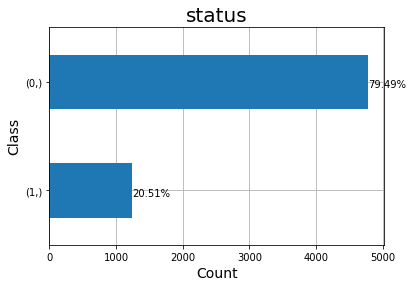

status
0         4785
1         1235
dtype: int64


In [380]:
# Plotting the percentage of observations that fall under each class
ax = pd.DataFrame(df.status).value_counts().sort_values().plot(kind="barh")
ax.set_axisbelow(True)
ax.grid()
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20,
     str(round((i.get_width()/total)*100, 2))+'%',
     fontsize=10, color='black')
plt.title("status", fontsize=20)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.show()
print(pd.DataFrame(df.status).value_counts())
fig = ax.get_figure()

The dataset is highly imbalanced with the majority class having 80% and the minority class 20%

Some techiques in handling class imbalance include;
 1. Using SMOTE to create synthetic data to reduce imbalanceness
 2. Undersampling the majority class
 3. Oversampling the minority class
 4. Giving more weight to minority class during modelling

<a name = "Outliers"></a>
## 7. Outliers

C:\Users\MSI\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\MSI\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\MSI\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result i

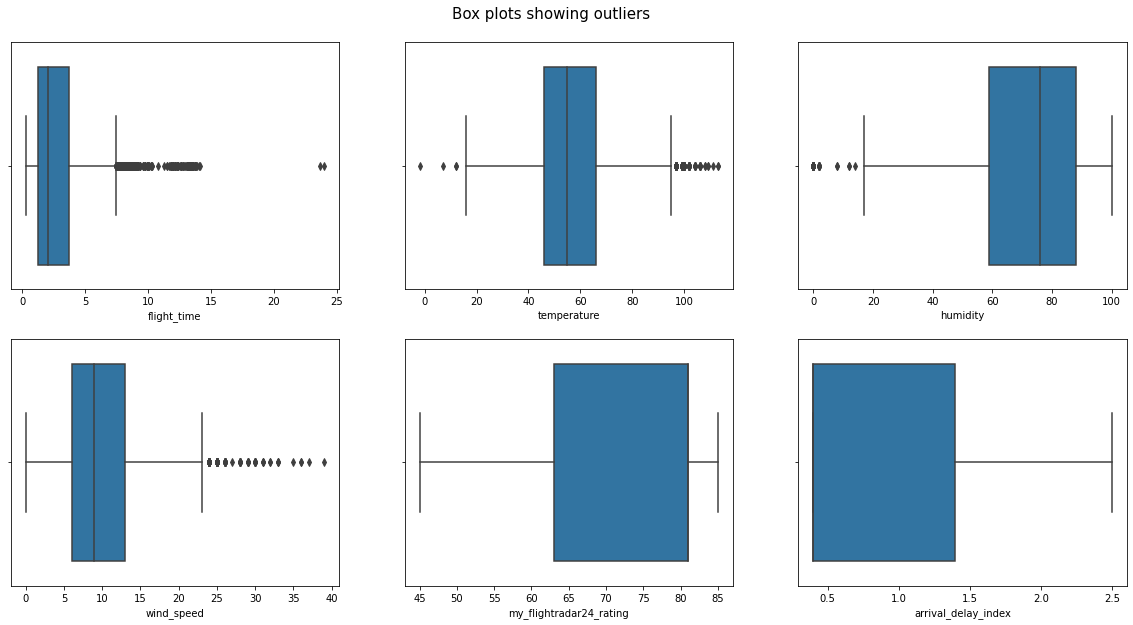

In [381]:
# Plotting boxplots for each of the numerical columns
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 10))
fig.suptitle('Box plots showing outliers', y= 0.93, fontsize = 15)

columns_to_plot = ['flight_time', 'temperature', 'humidity', 'wind_speed',
        'my_flightradar24_rating', 'arrival_delay_index', 'departure_delay_index']

for ax, data, name in zip(axes.flatten(), df, columns_to_plot):
  sns.boxplot(df[name], ax = ax)

 Some of the techniques we can use to handle outliers:
  1. Log transformations, scaling, box-cox transformations...
  2. Dropping the outliers
  3. Replacing the outliers with mean, median, mode or any other aggregates

### Numeric columns destribution

In [382]:
# # Determine number of columns
# num_columns = len(columns_to_plot)

# # Determine layout
# nrows = (num_columns // 2) + (num_columns % 2)
# ncols = 2 if num_columns > 1 else 1

In [383]:
# # Plotting histograms for each column
# df[columns_to_plot].hist(bins=10, figsize=(12, nrows * 4), alpha=0.7)
# plt.suptitle('Histograms')
# plt.show()

In [384]:
# # Plotting density plots for each column
# df[columns_to_plot].plot(kind='density', subplots=True, layout=(nrows, ncols), sharex=False, figsize=(12, nrows * 4), alpha=0.7)
# plt.suptitle('Density Plots')
# plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
# plt.show()

<a name = "Correlations"></a>
## 8. Correlations

In [385]:
# plt.figure(figsize = (20, 12))
# sns.pairplot(df[columns_to_plot], kind="scatter", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
# plt.show()

In [386]:
# plt.figure(figsize=(15,6))

# # plotting correlation heatmap
# dataplot = sns.heatmap(df[columns_to_plot].corr(), cmap="YlGnBu", annot=True)

# # displaying heatmap
# plt.show()

<a name = "Model"></a>
## 9. Model training

In [387]:
X = df.loc[:, df.columns != "status"]
y = np.array(df.loc[:, df.columns == "status"]["status"])

In [388]:
X.head()

,flight,from,to,from_city,to_city,flight_time,departure_delay,temperature,humidity,wind_speed,my_flightradar24_rating,arrival_delay_index,departure_delay_index,year,month,day,hour,dayofweek,quarter
0,329,157,7,142,6,1.016667,29.0,73,83,6,63,0.4,1.2,2023,8,18,21,4,3
1,257,80,3,72,3,0.900000,1386.0,95,71,9,78,0.4,0.8,2023,8,21,22,0,3
2,635,107,22,88,20,1.316667,7.0,54,72,7,85,0.4,0.7,2023,10,8,20,6,4
3,789,71,5,69,6,8.233333,38.0,45,100,7,81,0.4,0.8,2024,1,25,11,3,1
4,206,138,17,221,15,1.066667,12.0,50,62,13,71,2.5,2.5,2024,3,28,18,3,1


In [389]:
X.columns

Index(['flight', 'from', 'to', 'from_city', 'to_city', 'flight_time',
       'departure_delay', 'temperature', 'humidity', 'wind_speed',
       'my_flightradar24_rating', 'arrival_delay_index',
       'departure_delay_index', 'year', 'month', 'day', 'hour', 'dayofweek',
       'quarter'],
      dtype='object')

In [390]:
y[:100]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [391]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [392]:
print(f"\nDataset shape: {df.shape}")
print(f"X_train shape: {X_train.shape} | X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape} | y_test shape: {y_test.shape}")


Dataset shape: (6020, 20)
X_train shape: (4816, 19) | X_test shape: (1204, 19)
y_train shape: (4816,) | y_test shape: (1204,)


In [393]:
X_train.head()

,flight,from,to,from_city,to_city,flight_time,departure_delay,temperature,humidity,wind_speed,my_flightradar24_rating,arrival_delay_index,departure_delay_index,year,month,day,hour,dayofweek,quarter
5667,138,6,17,217,15,3.550000,22.0,50,94,4,71,2.5,2.5,2023,7,22,2,5,3
2355,52,70,11,70,4,4.883333,25.0,39,87,12,85,1.4,3.5,2024,2,2,22,4,1
3713,423,207,7,143,6,3.616667,4.0,36,93,8,63,0.4,1.2,2023,12,6,8,2,4
3219,120,22,17,15,15,4.783333,10.0,30,75,11,71,2.5,2.5,2023,11,17,14,4,4
5615,878,184,1,182,0,1.700000,37.0,55,94,2,64,2.5,2.5,2024,2,18,8,6,1


In [394]:
df.dtypes

flight                       int32
from                         int32
to                           int32
from_city                    int32
to_city                      int32
flight_time                float64
departure_delay            float64
temperature                  int32
humidity                     int32
wind_speed                   int32
my_flightradar24_rating      int32
arrival_delay_index        float32
departure_delay_index      float32
year                         int64
month                        int64
day                          int64
hour                         int64
dayofweek                    int64
quarter                      int64
status                       int32
dtype: object

## SMOTE

In [395]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

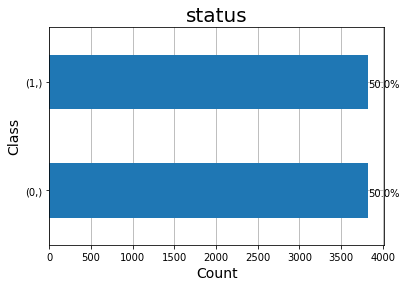

0    3828
1    3828
dtype: int64


In [396]:
# Plotting the percentage of observations that fall under each class
ax = pd.DataFrame(y_train).value_counts().sort_values().plot(kind="barh")
ax.set_axisbelow(True)
ax.grid()
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20,
     str(round((i.get_width()/total)*100, 2))+'%',
     fontsize=10, color='black')
plt.title("status", fontsize=20)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.show()
print(pd.DataFrame(y_train).value_counts())
fig = ax.get_figure()

## LGBM Classifier

In [397]:
model = LGBMClassifier()
model.fit(X_train, y_train)

LGBMClassifier()

In [398]:
model_pred = model.predict(X_test)
# print(confusion_matrix(labels_test, model_pred))
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       957
           1       0.80      0.87      0.83       247

    accuracy                           0.93      1204
   macro avg       0.88      0.91      0.89      1204
weighted avg       0.93      0.93      0.93      1204



In [399]:
# Save the model
joblib.dump(model, 'classifiers/lgbm_classifier.joblib')

['classifiers/lgbm_classifier.joblib']

In [400]:
np.unique(model_pred, return_counts=True)

(array([0, 1]), array([937, 267], dtype=int64))

## XGBoost

In [401]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

GradientBoostingClassifier()

In [402]:
model_pred = model.predict(X_test)
# print(confusion_matrix(labels_test, model_pred))
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       957
           1       0.74      0.86      0.80       247

    accuracy                           0.91      1204
   macro avg       0.85      0.89      0.87      1204
weighted avg       0.92      0.91      0.91      1204



In [403]:
# Save the model
joblib.dump(model, 'classifiers/xgboost_classifier.joblib')

['classifiers/xgboost_classifier.joblib']

In [404]:
np.unique(model_pred, return_counts=True)

(array([0, 1]), array([918, 286], dtype=int64))

## Random Forest

In [405]:
model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [406]:
model_pred = model.predict(X_test)
# print(confusion_matrix(labels_test, model_pred))
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       957
           1       0.78      0.85      0.81       247

    accuracy                           0.92      1204
   macro avg       0.87      0.90      0.88      1204
weighted avg       0.92      0.92      0.92      1204



In [407]:
# Save the model
joblib.dump(model, 'classifiers/random_forest_classifier.joblib')

['classifiers/random_forest_classifier.joblib']

In [408]:
np.unique(model_pred, return_counts=True)

(array([0, 1]), array([932, 272], dtype=int64))

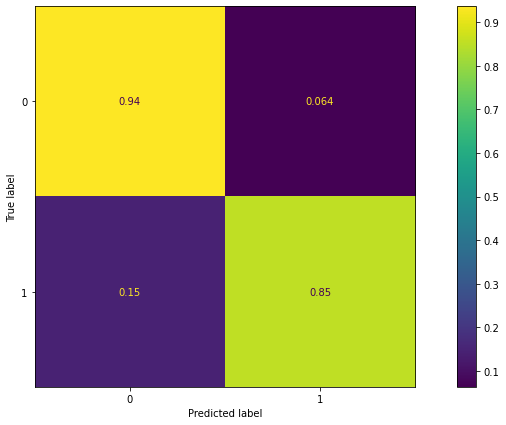

In [409]:
# Confusion matrix
cm = confusion_matrix(y_test, model_pred, labels=model.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
fig, ax = plt.subplots(figsize=(15,7))
disp.plot(ax=ax)
plt.show()

Text(0, 0.5, 'Features')

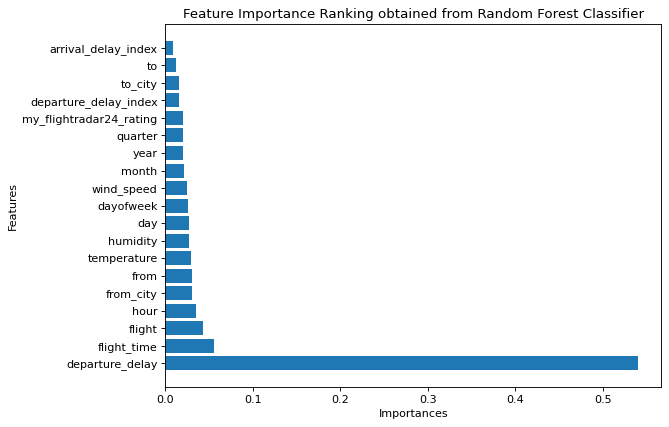

In [410]:
importances = pd.DataFrame({
    "Feature": list(X.columns),
    "Importance": model.feature_importances_
})
importances = importances.sort_values(by="Importance", ascending=False)
importances = importances.set_index("Feature")
importances
plt.figure(figsize=(8, 6), dpi=80)
plt.barh(importances.index, importances.Importance)
plt.title("Feature Importance Ranking obtained from Random Forest Classifier", fontsize=12)
plt.xlabel("Importances")
plt.ylabel("Features")

## To Do

- Correlations, normal distribution, outliers
- Use cross-validation techniques, GridSearchCV, RandomSearchCV
- Try different modelling techniques - Stacking classifier, Voting classifiers, ensembling...
- Feature Selection techniques such as RFE, Tree-based feature importance...